
Dataset shape: (398, 9)
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year  origin                    car name  
0          70       1  chevrolet chevelle malibu   
1          70       1           buick skylark 320  
2          70       1          plymouth satellite  
3          70       1               amc rebel sst  
4          70       1                 ford torino  



3/3 [==============================] - 0s 2ms/step
ANN Model - RMSE: 2.665, MAE: 1.799, R²: 0.870

Predicted MPG for input [[4.00e+00 9.70e+01 1.00e+02 5.00e+03 1.45e+01 7.00e+01 3.00e+00]]: 19.048
Predicted MPG for input [[8.000e+00 3.070

c:\Users\A507658\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\A507658\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


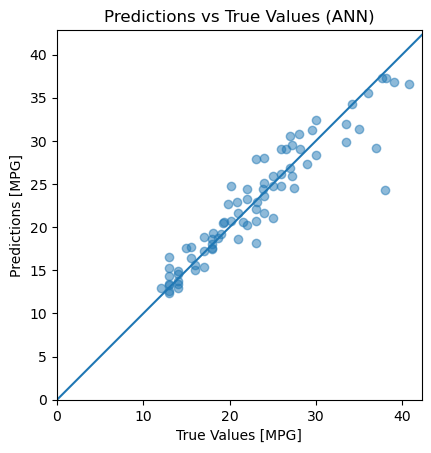

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import onnxmltools
import onnxruntime as ort

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/pydeveloperashish/Fuel-Efficiency-Prediction-using-ANN/refs/heads/main/Dataset.txt", na_values='?')
print("Dataset shape:", df.shape)
print(df.head())

# Data preprocessing
df.dropna(inplace=True)
df.drop(['car name'], axis=1, inplace=True)
X = df.drop("mpg", axis=1)
Y = df['mpg']

# Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

# Standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Save the scaler for future use
pickle.dump(sc, open('scaler.pkl', 'wb'))

# Define the ANN model
def create_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train the ANN model
ann_model = create_ann_model(X_train_std.shape[1])
ann_model.fit(X_train_std, Y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the ANN model on the test set
predictions = ann_model.predict(X_test_std)
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

# Print evaluation metrics for ANN model
print(f"ANN Model - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

# Save the ANN model as ONNX
onnx_model = onnxmltools.convert_keras(ann_model)
onnxmltools.utils.save_model(onnx_model, "ann_model.onnx")

# Load the ONNX model for inference using ONNX Runtime
ort_session = ort.InferenceSession("ann_model.onnx")

# Example input for prediction
example_input1 = np.array([[4, 97, 100, 5000, 14.5, 70, 3]], dtype=np.float32)
example_input2 = np.array([[8, 307, 130, 3504, 12, 70, 1]], dtype=np.float32)

# Standardize the example inputs
example_input1_std = sc.transform(example_input1)
example_input2_std = sc.transform(example_input2)

# Prepare inputs for ONNX model inference
input_name = ort_session.get_inputs()[0].name
prediction1 = ort_session.run(None, {input_name: example_input1_std})[0]
prediction2 = ort_session.run(None, {input_name: example_input2_std})[0]

# Print predictions from the ONNX model
print(f'Predicted MPG for input {example_input1}: {prediction1[0][0]:.3f}')
print(f'Predicted MPG for input {example_input2}: {prediction2[0][0]:.3f}')

# Plotting predictions vs true values
plt.scatter(Y_test, predictions, alpha=0.5)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.title('Predictions vs True Values (ANN)')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


In [2]:
def save_scaler_params(scaler, file_path):
    with open(file_path, 'w') as f:
        means = ','.join(map(str, scaler.mean_))
        scales = ','.join(map(str, scaler.scale_))
        f.write(means + '\n')
        f.write(scales + '\n')

# Call this after you fit the scaler
save_scaler_params(sc, 'scalers.txt')


In [3]:
import onnx

# Load the ONNX model
model = onnx.load("ann_model.onnx")

# Print input and output node names
print("Input names:")
for input in model.graph.input:
    print(input.name)

print("\nOutput names:")
for output in model.graph.output:
    print(output.name)


Input names:
dense_input

Output names:
dense_3
